In [4]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from joblib import Parallel, delayed
from IPython.display import clear_output

import warnings

warnings.filterwarnings('ignore')


1. RateConst Reader


In [5]:
def getAllRateInfo(file):   
    res=pd.DataFrame()
    try:
        temp=pd.read_csv(file)
        temp=temp.dropna()
        temp['Protein']=file.split('\\')[-1].replace('.RateConst.csv','')
        res=pd.concat([res,temp])
    except Exception as exp:
        return res
    
    return res
def getAllRate(data_path):
    results = Parallel(n_jobs=-1)(delayed(getAllRateInfo)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.RateConst.csv' in x  ]) 
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

2. Quant File Reader

In [6]:
def read_n_merge(skip,file):
    file_data=pd.read_csv(file,skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.split('\\')[-1].replace('.Quant.csv','') 
        return [isparsed,file_data]
    else:
        return [isparsed,None]
def get_df_all_quant_files(file):
    res=read_n_merge(1,file)
    all_data=None
    if res[0]: all_data=res[1]
    else: all_data=read_n_merge(3,file)[1]
    return all_data

def getquantfile(data_path):
    results = Parallel(n_jobs=-1)(delayed(get_df_all_quant_files)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.Quant.csv' in x  ])
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data


def plotRateRDDensity(rd_k,col,title=""):
    
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"{title} n={len(rd_k)},\nμ = {int(100*np.mean(rd_k))/100}, median = {int(100*np.median(rd_k))/100}, sd = {int(100*np.std(rd_k))/100}",
                color=col,alpha=0.1,edgecolor=(col,0.1) )
    # ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    # ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel("Relative difference ( "+  r'$\frac{ I_{0}(0)^{theo} - I_{0}(t)^{exp} }{I_{0}(0)^{theo}}$' +" , " + r'$\frac{ I_{0}(0)^{theo} - I_{0}(t)^{exp} }{I_{0}(0)^{theo}}$'+ " )")
    plt.legend(bbox_to_anchor=(1.55, 1), loc='upper right', borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.xlim([-0.4,0.4])
    

3. Data source & path

In [7]:
def getData(organ):
    path=""
    
    if organ== 'liver':path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
    if organ== 'heart':path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
    if organ== 'kidney':path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_kidney'
    if organ== 'muscle':path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


    rsquared = 0.9

    data_quant=getquantfile(path)
    data_rate=getAllRate(path)
    data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]


    merged=pd.merge(data_quant,
                    data_rate,
                    left_on=['Protein','Peptide','Charge'],
                    right_on=['Protein','Peptides','Charge'])
    merged=merged.reset_index(drop=True)


    merged=merged[(merged.Rsquared.astype('float')>=rsquared) &
                (merged.RateConstants< math.log(2))]
    merged=merged.reset_index(drop=True)
    merged=merged[merged.I0 != ' ']
    merged=merged[merged.I0.astype('float')+merged.I1.astype('float')+merged.I2.astype('float')+merged.I3.astype('float')+merged.I4.astype('float')+merged.I5.astype('float')>0]
    merged['RIA']=merged.I0.astype('float')/ (merged.I0.astype('float')+merged.I1.astype('float')+merged.I2.astype('float')+merged.I3.astype('float')+merged.I4.astype('float')+merged.I5.astype('float'))
    merged['M0']=merged['M0']/100
    print(organ,merged.shape)
    return merged

In [8]:
liver=getData('liver')
kidney=getData('kidney')
heart=getData('heart')
muscle=getData('muscle')

liver (8943, 220)
kidney (7375, 218)
heart (5825, 218)
muscle (5320, 220)


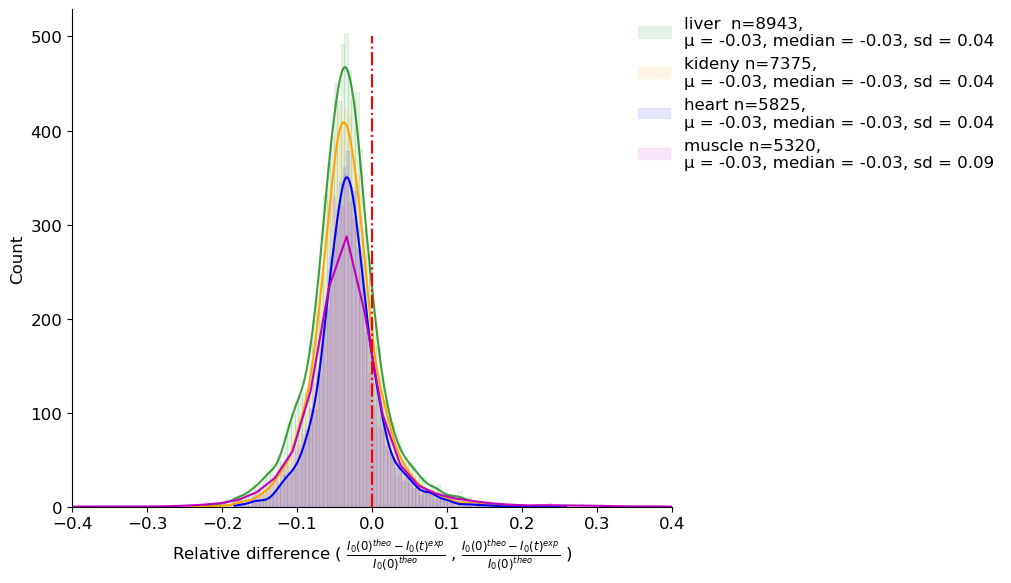

In [9]:
plt.rc('font',size=12)
plt.figure(figsize=(10,6)) 

plotRateRDDensity((liver['M0'] - liver['RIA'] ) /liver['RIA'],'g',"liver ")
plotRateRDDensity((kidney['M0'] - kidney['RIA'] ) /kidney['RIA'],'orange',"kideny")
plotRateRDDensity((heart['M0'] - heart['RIA'] ) /heart['RIA'],'b',"heart")
plotRateRDDensity((muscle['M0'] - muscle['RIA'] ) /muscle['RIA'],'m',"muscle")

plt.vlines(x=0,ymin=0,ymax=500,ls='-.',colors='r')